<a href="https://colab.research.google.com/github/balados85/ML_Labs/blob/main/Assignment_Name_and_City_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
import matplotlib.pyplot as plt

In [85]:
from google.colab import drive
drive.mount('/content/drive')

path = 'drive/MyDrive/data/cities/*.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

In [87]:
def findFiles(path): return glob.glob(path)

In [88]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

In [89]:
# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles(path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 6 ['UnitedKingdom', 'UnitedStates', 'Ghana', 'Sweden', 'Canada', 'France']
O'Neal


In [90]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.first = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.second = nn.Linear(n_categories + input_size + hidden_size, output_size)
        #self.third = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.fourth = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.first(input_combined)
        output = self.second(input_combined)
        #output = self.third(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.fourth(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [91]:
# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    category_line = category_lines[category]
    line = category_line[random.randint(0, len(category_line) - 1)]
    return category, line

In [92]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [93]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [97]:
criterion = nn.NLLLoss()
learning_rate = 0.0003
optimizer = torch.optim.RMSprop(rnn.parameters(), lr=learning_rate)

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    optimizer.step()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [98]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [99]:
rnn = RNN(n_letters, 256, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 28s (5000 5%) 3.2907
0m 56s (10000 10%) 2.6996
1m 24s (15000 15%) 2.6461
1m 52s (20000 20%) 3.0952
2m 20s (25000 25%) 3.6005
2m 49s (30000 30%) 2.3969
3m 17s (35000 35%) 2.2917
3m 44s (40000 40%) 1.8342
4m 12s (45000 45%) 2.0971
4m 40s (50000 50%) 2.3439
5m 8s (55000 55%) 2.6025
5m 36s (60000 60%) 1.9810
6m 3s (65000 65%) 2.5083
6m 31s (70000 70%) 3.5157
6m 59s (75000 75%) 2.5151
7m 27s (80000 80%) 1.8624
7m 56s (85000 85%) 2.3974
8m 24s (90000 90%) 1.0824
8m 51s (95000 95%) 2.6274
9m 20s (100000 100%) 2.1836


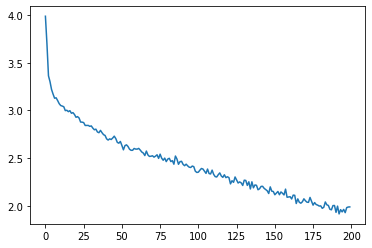

In [100]:
plt.figure()
plt.plot(all_losses)

In [101]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name+" : "+category

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Ghana', 'GHA')

samples('UnitedKingdom', 'UK')

samples('UnitedStates', 'USA')

samples('Canada', 'CAN')

samples('Sweden', 'SWE')

samples('France','FRA')

Gaman : Ghana
Ho : Ghana
Aacha : Ghana
Uerderle : UnitedKingdom
Kiestidsand : UnitedKingdom
Uana : UnitedStates
Storaston : UnitedStates
Arestor : UnitedStates
Colle rake : Canada
Aringe : Canada
Nerring : Canada
Sandsarg : Sweden
Wallo : Sweden
Eale : Sweden
Forten : France
Roure : France
Auringe : France
